In [6]:
%pip install -q rhino3dm shapely trimesh matplotlib pyvista pandas
%pip install PyniteFEA[all]
%pip install Pynite
%pip install trimesh

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
print (df_beams ,df_columns, df_nodes)

NameError: name 'df_beams' is not defined

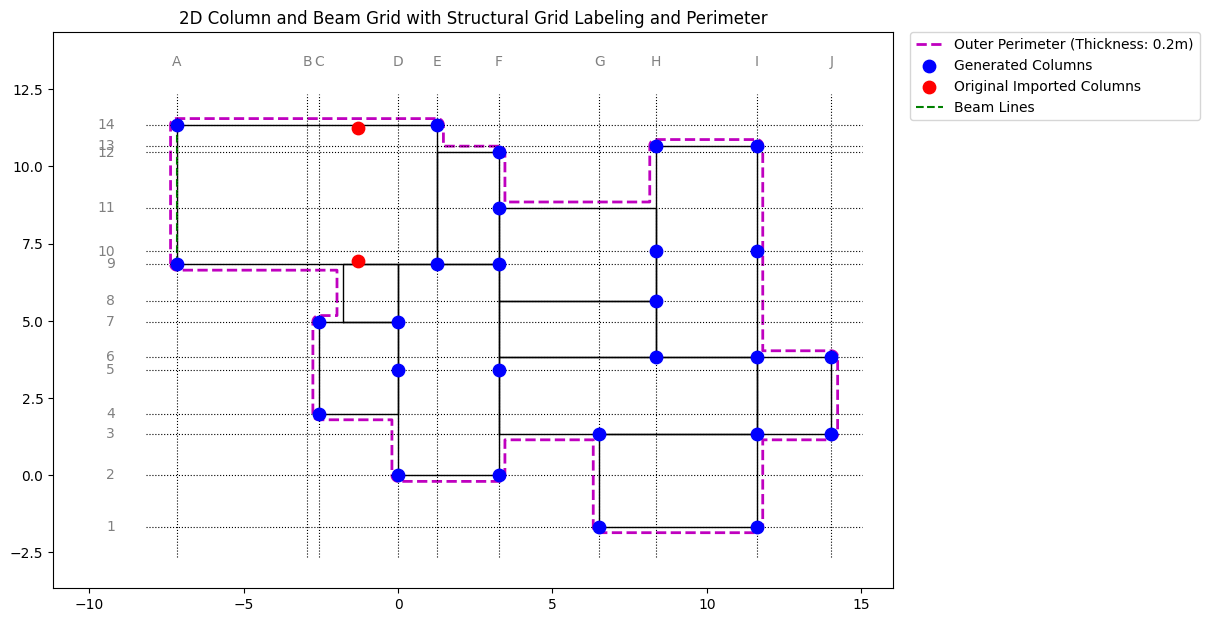

Widget(value='<iframe src="http://localhost:54333/index.html?ui=P_0x24e0370ded0_7&reconnect=auto" class="pyvis…


COLUMN SLENDERNESS CHECK (L/r):
  Column C0: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
  Column C1: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
  Column C2: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
  Column C3: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
  Column C4: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
  Column C5: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
  Column C6: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
  Column C7: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
  Column C8: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
  Column C9: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
  Column C10: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
  Column C11: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
  Column C12: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
  Column C13: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
  Column C14: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
  Column C15: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
  Column C16: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
  Column C17: L=118.11 in, r=1.28 in → L/r

In [ ]:
import rhino3dm
import numpy as np
from shapely.geometry import Polygon, Point, MultiPolygon, LineString
import matplotlib.pyplot as plt
import os
import pyvista as pv
import csv # Import the csv module

# File path
# Note: Using the remembered path from your previous interactions.
rhino_path = r"..\Reference Files\rectangles3dcantileverarchitectural.3dm" # Updated to your remembered path
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_volumes = []
imported_columns = []
max_z = 0.0 # Global maximum Z for the entire building footprint

wall_breps = []

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        base_pts = [
            [bbox.Min.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Max.Y] # Ensure polygon is closed for Shapely
        ]
        poly = Polygon(base_pts)
        building_volumes.append(poly)
        wall_breps.append({'polygon': poly, 'bbox': bbox})
        max_z = max(max_z, bbox.Max.Z) # Update global max_z

    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_volumes:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2 for ground + 1 middle + roof): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# --- Section for perimeter line and wall thickness ---
while True:
    try:
        wall_thickness = float(input("Enter desired wall thickness for the perimeter (e.g., 0.3): "))
        if wall_thickness <= 0:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive number for wall thickness.")

# Combine all building polygons into a single MultiPolygon
combined_building_polygon = MultiPolygon(building_volumes)

# Get the exterior boundary of the combined building and offset it
try:
    exterior_perimeter = combined_building_polygon.buffer(wall_thickness, join_style=1) # join_style=1 for mitered joints
except Exception as e:
    print(f"Could not buffer the building outline. Error: {e}")
    exterior_perimeter = None

# If the buffer operation results in a MultiPolygon, get the largest component
if exterior_perimeter and exterior_perimeter.geom_type == 'MultiPolygon':
    exterior_perimeter = max(exterior_perimeter.geoms, key=lambda p: p.area)

perimeter_line_coords = []
if exterior_perimeter:
    if exterior_perimeter.geom_type == 'Polygon':
        # Extract the exterior ring coordinates
        perimeter_line_coords = list(exterior_perimeter.exterior.coords)
    elif exterior_perimeter.geom_type == 'MultiPolygon':
        # For MultiPolygon, take the exterior of the largest polygon component
        perimeter_line_coords = list(exterior_perimeter.geoms[0].exterior.coords)
    else:
        print("Warning: The buffered perimeter is not a Polygon or MultiPolygon. Cannot extract line coordinates.")

# --- End perimeter section ---

# Room sorting
detected_rooms = sorted([(poly, poly.area) for poly in building_volumes], key=lambda x: -x[1])

# Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy()
beams = []

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    width, height = maxx - minx, maxy - miny
    divisions_x = int(np.ceil(width / MaxS))
    divisions_y = int(np.ceil(height / MaxS))
    x_points = np.linspace(minx, maxx, divisions_x + 1)
    y_points = np.linspace(miny, maxy, divisions_y + 1)
    room_candidates = [(x, y) for x in x_points for y in y_points]

    for col in room_candidates:
        snap = False
        for imp_col in available_imported:
            if np.linalg.norm(np.array(col) - np.array(imp_col)) < MinS:
                corrected_columns.append(col)
                existing_columns.append(col)
                available_imported.remove(imp_col)
                snap = True
                break
        if not snap and all(np.linalg.norm(np.array(col) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col)
            existing_columns.append(col)

    for x in x_points:
        beams.append(((x, miny), (x, maxy)))
    for y in y_points:
        beams.append(((minx, y), (maxx, y)))

    for corner in list(room_poly.exterior.coords):
        if all(np.linalg.norm(np.array(corner) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
            columns.append(corner)
            existing_columns.append(corner)

# Combine all base columns
all_base_columns = columns + corrected_columns

# --- COLUMN GRID NUMBERING LOGIC ---
# Get unique X and Y coordinates from all generated/snapped columns for grid lines
grid_xs = sorted(list(set([col[0] for col in all_base_columns])))
grid_ys = sorted(list(set([col[1] for col in all_base_columns])))

# Create mapping for X-coordinates to letters (A, B, C...)
x_grid_labels = {x: chr(65 + i) for i, x in enumerate(grid_xs)}
# Create mapping for Y-coordinates to numbers (1, 2, 3...)
y_grid_labels = {y: i + 1 for i, y in enumerate(grid_ys)}

# Determine the actual min/max X/Y of the columns for drawing grid lines
col_min_x_extent = min(col[0] for col in all_base_columns) if all_base_columns else 0
col_max_x_extent = max(col[0] for col in all_base_columns) if all_base_columns else 0
col_min_y_extent = min(col[1] for col in all_base_columns) if all_base_columns else 0
col_max_y_extent = max(col[1] for col in all_base_columns) if all_base_columns else 0

# Add a small buffer to the column extents for drawing grid lines
grid_extent_buffer = 1.0 # Adjusted for better visual spacing
col_min_x_extent -= grid_extent_buffer
col_max_x_extent += grid_extent_buffer
col_min_y_extent -= grid_extent_buffer
col_max_y_extent += grid_extent_buffer

# Determine overall plot limits (consider building outline and grid labels)
# Adjusted limits to provide more space for labels without cutting off the perimeter
# Increased padding for labels
min_x_plot = min(col_min_x_extent, min([coord[0] for coord in perimeter_line_coords] + [col[0] for col in all_base_columns])) - 3.0 if perimeter_line_coords else col_min_x_extent - 3.0
max_x_plot = max(col_max_x_extent, max([coord[0] for coord in perimeter_line_coords] + [col[0] for col in all_base_columns])) + 1.0 if perimeter_line_coords else col_max_x_extent + 1.0
min_y_plot = min(col_min_y_extent, min([coord[1] for coord in perimeter_line_coords] + [col[1] for col in all_base_columns])) - 1.0 if perimeter_line_coords else col_min_y_extent - 1.0
max_y_plot = max(col_max_y_extent, max([coord[1] for coord in perimeter_line_coords] + [col[1] for col in all_base_columns])) + 2.0 if perimeter_line_coords else col_max_y_extent + 2.0


# 2D Visualization
fig, ax = plt.subplots(figsize=(12, 10)) # Increased figure width for legend

# Room outlines
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1)

# Plot the new perimeter line
if perimeter_line_coords:
    px_perimeter, py_perimeter = zip(*perimeter_line_coords)
    ax.plot(px_perimeter, py_perimeter, 'm--', linewidth=2, label=f'Outer Perimeter (Thickness: {wall_thickness}m)')

# Plot all columns
gx, gy = zip(*columns)
ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

# Only draw one label for beam lines in 2D
if beams:
    x1, y1 = beams[0][0]
    x2, y2 = beams[0][1]
    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5, label='Beam Lines')

# Draw and label grid lines
# Increased offset for labels for better clarity
for x_coord in grid_xs:
    ax.plot([x_coord, x_coord], [col_min_y_extent, col_max_y_extent], 'k:', linewidth=0.8) # Dashed vertical grid line
    ax.text(x_coord, col_max_y_extent + 0.8, x_grid_labels[x_coord], ha='center', va='bottom', fontsize=10, color='gray') # Label at top

for y_coord in grid_ys:
    ax.plot([col_min_x_extent, col_max_x_extent], [y_coord, y_coord], 'k:', linewidth=0.8) # Dashed horizontal grid line
    ax.text(col_min_x_extent - 1.0, y_coord, y_grid_labels[y_coord], ha='right', va='center', fontsize=10, color='gray') # Label on left


ax.set_aspect('equal', 'box')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.) # Moved legend
plt.title("2D Column and Beam Grid with Structural Grid Labeling and Perimeter")

# Using subplots_adjust for explicit margin control instead of tight_layout
# This gives more precise control over the margins for labels
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1) # Adjusted values for left and top margin


ax.set_xlim(min_x_plot, max_x_plot)
ax.set_ylim(min_y_plot, max_y_plot)
plt.show()

# PyVista 3D visualization
plotter = pv.Plotter(title="3D Structural System")

# Define sizes for structural elements (now dimensions for rectangular prisms)
column_width = 0.3
column_depth = 0.3

beam_width = 0.25
beam_depth = 0.35

slab_thickness = 0.20

slab_extension_buffer = max(column_width, column_depth) / 2 + 0.05

# Calculate story heights per room, since rooms might have different max Z
room_story_heights = {}
for room_poly, _ in detected_rooms:
    room_specific_max_z = 0.0
    for wall_data in wall_breps:
        if wall_data['polygon'].equals(room_poly):
            room_specific_max_z = wall_data['bbox'].Max.Z
            break
    if room_specific_max_z == 0.0:
        room_specific_max_z = max_z
    
    num_vertical_sections = num_floors 

    if num_vertical_sections > 0:
        story_height = room_specific_max_z / num_vertical_sections
    else:
        story_height = room_specific_max_z
    
    room_story_heights[room_poly.wkt] = story_height


# --- Define Z-levels for each floor in a more structured way ---
floor_z_levels = {} 
for room_poly, _ in detected_rooms:
    room_specific_max_z = 0.0
    for wall_data in wall_breps:
        if wall_data['polygon'].equals(room_poly):
            room_specific_max_z = wall_data['bbox'].Max.Z
            break
    if room_specific_max_z == 0.0:
        room_specific_max_z = max_z

    current_room_floor_z = []
    
    # Slab 0: Ground Slab
    current_room_floor_z.append((0.0, slab_thickness))

    if num_floors > 0: # Only generate intermediate and roof slabs if there's at least 1 floor
        story_height = room_story_heights.get(room_poly.wkt, max_z)
        
        # Intermediate Slabs (from 1 to num_floors-1)
        for i in range(1, num_floors): 
            slab_base_z = i * story_height
            slab_top_z = slab_base_z + slab_thickness

            if slab_top_z > room_specific_max_z + 1e-6:
                slab_top_z = room_specific_max_z
                slab_base_z = max(slab_base_z, slab_top_z - slab_thickness)

            if slab_top_z - slab_base_z < 1e-6:
                continue
                
            current_room_floor_z.append((slab_base_z, slab_top_z))
        
        # Last Slab: Roof Slab
        roof_slab_top_z = room_specific_max_z 
        roof_slab_base_z = roof_slab_top_z - slab_thickness
        
        if current_room_floor_z:
            last_slab_top = current_room_floor_z[-1][1]
            if roof_slab_base_z < last_slab_top + 1e-6:
                roof_slab_base_z = last_slab_top
                roof_slab_top_z = roof_slab_base_z + slab_thickness
                if roof_slab_top_z > room_specific_max_z + 1e-6:
                    roof_slab_top_z = room_specific_max_z
                    roof_slab_base_z = max(roof_slab_top_z - slab_thickness, last_slab_top)
        
        if roof_slab_top_z - roof_slab_base_z < 1e-6:
            pass
        else:
            current_room_floor_z.append((roof_slab_base_z, roof_slab_top_z))

    floor_z_levels[room_poly.wkt] = current_room_floor_z

# --- Add Slabs ---
for room_poly, _ in detected_rooms:
    nodes_df = floor_z_levels.get(room_poly.wkt, [])
    if not nodes_df:
        continue

    extended_room_poly = room_poly.buffer(slab_extension_buffer)
    
    for i, (slab_base_z, slab_top_z) in enumerate(nodes_df):
        current_slab_thickness = slab_top_z - slab_base_z
        if current_slab_thickness < 1e-6:
            continue

        points_3d_for_slab_base = []
        poly_coords = list(extended_room_poly.exterior.coords)
        if poly_coords[0] != poly_coords[-1]:
            poly_coords.append(poly_coords[0])
            
        for x, y in poly_coords:
            points_3d_for_slab_base.append([x, y, 0.0])
        
        points_3d_for_slab_base = np.array(points_3d_for_slab_base)

        if len(points_3d_for_slab_base) < 3:
            continue

        slab_base_mesh = pv.PolyData(points_3d_for_slab_base)
        
        try:
            triangulated_faces = slab_base_mesh.delaunay_2d().faces
            if triangulated_faces is None or len(triangulated_faces) == 0:
                continue
            slab_base_mesh = pv.PolyData(points_3d_for_slab_base, faces=triangulated_faces)
        except Exception as e:
            print(f"Delaunay triangulation failed for a slab base ({room_poly.bounds}): {e}. Skipping slab.")
            continue

        slab_mesh = slab_base_mesh.extrude(vector=(0, 0, current_slab_thickness), capping=True)
        slab_mesh = slab_mesh.translate((0, 0, slab_base_z))
        
        plotter.add_mesh(slab_mesh, color='sienna', opacity=0.8, smooth_shading=True)


# --- Data Structures for Export ---
all_nodes_data = {} # (x, y, z) -> "N_ID"
export_columns = [] # List of {"ID": "C0", "i_node": "N0", "j_node": "N1"}
export_beams = []   # List of {"ID": "B0", "i_node": "N0", "j_node": "N1"}
node_id_counter = 0

def get_node_id(x, y, z):
    global node_id_counter
    # Use a tuple (x, y, z) as key, rounded to avoid floating point issues
    # Adjust rounding precision as needed
    rounded_coords = (round(x, 6), round(y, 6), round(z, 6))
    if rounded_coords not in all_nodes_data:
        node_id = f"N{node_id_counter}"
        all_nodes_data[rounded_coords] = node_id
        node_id_counter += 1
    return all_nodes_data[rounded_coords]

# --- Add Columns (and populate export_columns, all_nodes_data) ---
column_id_counter = 0
for x, y in all_base_columns:
    column_room_wkt = None
    for room_poly, _ in detected_rooms:
        if Point(x, y).within(room_poly):
            column_room_wkt = room_poly.wkt
            break
    if column_room_wkt is None:
        min_dist = float('inf')
        for room_poly, _ in detected_rooms:
            dist = Point(x,y).distance(room_poly)
            if dist < min_dist:
                min_dist = dist
                column_room_wkt = room_poly.wkt
        if column_room_wkt is None:
             continue

    nodes_df = floor_z_levels.get(column_room_wkt, [])
    if not nodes_df or len(nodes_df) <= 1:
        continue
    
    num_slabs_in_room = len(nodes_df)
    
    for i in range(num_slabs_in_room - 1):
        col_base_z = nodes_df[i][1] 
        col_top_z = nodes_df[i+1][0] 

        if col_top_z <= col_base_z + 1e-6:
            continue

        col_min_x = x - column_width / 2
        col_max_x = x + column_width / 2
        col_min_y = y - column_depth / 2
        col_max_y = y + column_depth / 2
        
        column_box = pv.Box([col_min_x, col_max_x, col_min_y, col_max_y, col_base_z, col_top_z])
        plotter.add_mesh(column_box, color='blue', smooth_shading=True)

        # Collect data for export_columns
        i_node_id = get_node_id(x, y, col_base_z)
        j_node_id = get_node_id(x, y, col_top_z)
        export_columns.append({"ID": f"C{column_id_counter}", "i_node": i_node_id, "j_node": j_node_id})
        column_id_counter += 1


# --- Add Beams (and populate export_beams, all_nodes_data) ---
beam_id_counter = 0
for (x1, y1), (x2, y2) in beams:
    full_beam_line = LineString([(x1, y1), (x2, y2)])

    for i in range(len(nodes_df)): # Iterate through floor levels (slabs)
        relevant_rooms_for_this_floor = []
        for room_poly, _ in detected_rooms:
            if room_poly.intersects(full_beam_line.buffer(1e-3)):
                nodes_df_current_room = floor_z_levels.get(room_poly.wkt, [])
                if len(nodes_df_current_room) > i:
                    slab_base_z_for_this_room_floor = nodes_df_current_room[i][0]
                    # slab_top_z_for_this_room_floor = nodes_df_current_room[i][1] # Not directly used for beam z here

                    room_specific_max_z = 0.0
                    for wall_data in wall_breps:
                        if wall_data['polygon'].equals(room_poly):
                            room_specific_max_z = wall_data['bbox'].Max.Z
                            break
                    if room_specific_max_z == 0.0: room_specific_max_z = max_z

                    if slab_base_z_for_this_room_floor >= room_specific_max_z - 1e-6 and i < len(nodes_df_current_room) -1:
                        continue 
                    
                    relevant_rooms_for_this_floor.append((room_poly, slab_base_z_for_this_room_floor))

        if not relevant_rooms_for_this_floor:
            continue

        for room_poly, slab_base_z_for_current_room in relevant_rooms_for_this_floor:
            intersection = full_beam_line.intersection(room_poly)

            if intersection.geom_type == 'LineString':
                segments_to_draw = [intersection]
            elif intersection.geom_type == 'MultiLineString':
                segments_to_draw = list(intersection.geoms)
            else: 
                continue

            for segment in segments_to_draw:
                if not segment.is_empty and segment.length > 1e-6:
                    seg_x1, seg_y1 = segment.coords[0]
                    seg_x2, seg_y2 = segment.coords[-1]

                    beam_top_z = slab_base_z_for_current_room
                    beam_base_z = beam_top_z - beam_depth

                    if beam_base_z < 0:
                        beam_base_z = 0
                        if beam_top_z <= 0:
                            continue
                    
                    if beam_top_z <= beam_base_z + 1e-6:
                        continue

                    if abs(seg_x1 - seg_x2) > abs(seg_y1 - seg_y2):
                        beam_min_x = min(seg_x1, seg_x2)
                        beam_max_x = max(seg_x1, seg_x2)
                        beam_center_y = (seg_y1 + seg_y2) / 2
                        beam_min_y = beam_center_y - beam_width / 2
                        beam_max_y = beam_center_y + beam_width / 2
                    else:
                        beam_min_y = min(seg_y1, seg_y2)
                        beam_max_y = max(seg_y1, seg_y2)
                        beam_center_x = (seg_x1 + seg_x2) / 2
                        beam_min_x = beam_center_x - beam_width / 2
                        beam_max_x = beam_center_x + beam_width / 2

                    beam_box = pv.Box([beam_min_x, beam_max_x, beam_min_y, beam_max_y, beam_base_z, beam_top_z])

                    is_roof_slab = (i == len(nodes_df_current_room) - 1)
                    color = 'green' if is_roof_slab else 'orange' 
                    plotter.add_mesh(beam_box, color=color, smooth_shading=True)

                    # Collect data for export_beams
                    # Beams' nodes are at their centerlines (seg_x1, seg_y1, beam_top_z) and (seg_x2, seg_y2, beam_top_z)
                    i_node_id = get_node_id(seg_x1, seg_y1, beam_top_z)
                    j_node_id = get_node_id(seg_x2, seg_y2, beam_top_z)
                    export_beams.append({"ID": f"B{beam_id_counter}", "i_node": i_node_id, "j_node": j_node_id})
                    beam_id_counter += 1

# Convert all_nodes_data dictionary to a list of dictionaries for CSV export
final_nodes_data = []
for coords, node_id in all_nodes_data.items():
    final_nodes_data.append({"ID": node_id, "X": coords[0], "Y": coords[1], "Z": coords[2]})

# Actual Brep-based walls visualization (semi-transparent)
def mesh_brep(brep, mesh_type=rhino3dm.MeshType.Any):
    meshes = []
    for face in brep.Faces:
        try:
            m = face.GetMesh(mesh_type)
            if m: meshes.append(m)
        except:
            continue
    return meshes

for obj in model.Objects:
    geom = obj.Geometry
    layer_idx = obj.Attributes.LayerIndex
    if layer_idx == layers['building'] and isinstance(geom, rhino3dm.Brep):
        meshes = mesh_brep(geom)
        for mesh in meshes:
            pts = [(v.X, v.Y, v.Z) for v in mesh.Vertices]
            faces = []
            for f in mesh.Faces:
                if len(f) == 4:
                    idxs = (f[0], f[1], f[2], f[3])
                else:
                    idxs = (f[0], f[1], f[2])
                faces.append((len(idxs),) + idxs)
            faces_flat = [i for face in faces for i in face]
            pv_mesh = pv.PolyData(pts, faces_flat)
            plotter.add_mesh(pv_mesh, color='lightgray', opacity=0.3)

plotter.show_grid()
plotter.show()


import pandas as pd
import numpy as np
import plotly.graph_objects as go
from collections import OrderedDict
import os # Import the os module for path operations


# --- ASSUMPTION: Your rhino3dm processing code (from the previous turn) ---
# --- has already run and populated these variables: ---
# max_z
# num_floors
# all_base_columns (list of (x,y) tuples for column base points)
# beams (list of ((x1,y1), (x2,y2)) tuples for beam definitions)
# wall_breps (list of {'polygon': shapely_poly, 'bbox': rhino3dm_bbox} for wall height lookup)
# detected_rooms (list of (shapely_poly, area) for room polygons)
# perimeter_line_coords (list of (x,y) tuples for the base perimeter)

# For this code to run, you MUST execute your previous cell that uses rhino3dm
# to generate the above variables. If you run ONLY this cell, these variables will be undefined.

# --- Utility function for wall height (re-used from your code) ---
from shapely.geometry import Point # Ensure Point is imported for get_wall_height
def get_wall_height(x, y, wall_data, global_max_z):
    pt = Point(x, y)
    closest_wall_height = global_max_z # Default to global max_z if no specific wall found
    min_dist_to_wall = float('inf')

    for wall in wall_data:
        if wall['polygon'].contains(pt):
            return wall['bbox'].Max.Z # If the point is inside a wall's base polygon
        
        dist = wall['polygon'].exterior.distance(pt)
        if dist < min_dist_to_wall:
            min_dist_to_wall = dist
            closest_wall_height = wall['bbox'].Max.Z
    
    return closest_wall_height # Return the height of the closest wall or global max_z



node_coords = []
node_dict = OrderedDict() # Maps (x,y,z) tuple to node ID

def add_node(pt):
    key = tuple(np.round(pt, 5))
    if key not in node_dict:
        node_id = f"N{len(node_dict)}"
        node_dict[key] = node_id
        node_coords.append([node_id] + list(key))
    return node_dict[key]

# Ensure column_lines and beam_lines are populated based on the processed data
column_lines = []
for x, y in all_base_columns: # Use all_base_columns directly for vertical elements
    current_column_max_z = get_wall_height(x,y, wall_breps, max_z)
    
    # Generate nodes for each floor level for columns
    for i in range(num_floors + 1): # Including ground (0) and roof (num_floors)
        z_level = (i / num_floors) * current_column_max_z
        if i == 0: # Base of the column
            id_btm = add_node((x, y, 0))
            id_top = add_node((x, y, z_level))
            if z_level > 0: # Only add if it forms a segment
                 column_lines.append((id_btm, id_top))
        elif i > 0: # For subsequent segments between floors
            prev_z_level = ((i-1) / num_floors) * current_column_max_z
            id_prev_node = add_node((x, y, prev_z_level))
            id_current_node = add_node((x, y, z_level))
            column_lines.append((id_prev_node, id_current_node))


beam_lines = []
for (x1, y1), (x2, y2) in beams:
    # Beams exist at each floor level (from 1st floor to roof)
    segment_max_z_for_height = min(get_wall_height(x1, y1, wall_breps, max_z), get_wall_height(x2, y2, wall_breps, max_z))
    
    for i in range(1, num_floors + 1):
        z_level = (i / num_floors) * segment_max_z_for_height
        
        # Ensure beams don't extend above the actual wall height (with a tiny tolerance)
        if z_level > (segment_max_z_for_height + 1e-6):
            continue

        id1 = add_node((x1, y1, z_level))
        id2 = add_node((x2, y2, z_level))
        beam_lines.append((id1, id2))


# --- Export nodes.csv ---
nodes_df = pd.DataFrame(node_coords, columns=["ID", "X", "Y", "Z"])

# --- Export columns.csv ---
col_data = []
for i, (i_node_id, j_node_id) in enumerate(column_lines):
    # Lookup coordinates from the generated nodes_df
    p1_coords = nodes_df[nodes_df["ID"] == i_node_id][["X", "Y", "Z"]].values[0]
    p2_coords = nodes_df[nodes_df["ID"] == j_node_id][["X", "Y", "Z"]].values[0]
    length = np.linalg.norm(p2_coords - p1_coords)
    col_data.append([f"C{i}", i_node_id, j_node_id, round(length, 3)])

columns_df = pd.DataFrame(col_data, columns=["ID", "i_node", "j_node", "length"])


# --- Export beams.csv ---
beam_data = []
for i, (i_node_id, j_node_id) in enumerate(beam_lines):
    # Lookup coordinates from the generated nodes_df
    p1_coords = nodes_df[nodes_df["ID"] == i_node_id][["X", "Y", "Z"]].values[0]
    p2_coords = nodes_df[nodes_df["ID"] == j_node_id][["X", "Y", "Z"]].values[0]
    length = np.linalg.norm(p2_coords - p1_coords)
    beam_data.append([f"B{i}", i_node_id, j_node_id, round(length, 3)])

beams_df = pd.DataFrame(beam_data, columns=["ID", "i_node", "j_node", "length"])


# Create a dictionary for quick node coordinate lookup by ID from the loaded data
node_lookup_loaded = nodes_df.set_index('ID')[['X', 'Y', 'Z']].T.to_dict('list')

# Prepare data for plotting lines (columns and beams)
column_plotly_lines_x, column_plotly_lines_y, column_plotly_lines_z = [], [], []
beam_plotly_lines_x, beam_plotly_lines_y, beam_plotly_lines_z = [], [], []

# Add Columns to line data
for index, row in columns_df.iterrows():
    p1 = node_lookup_loaded[row['i_node']]
    p2 = node_lookup_loaded[row['j_node']]
    column_plotly_lines_x.extend([p1[0], p2[0], None])
    column_plotly_lines_y.extend([p1[1], p2[1], None])
    column_plotly_lines_z.extend([p1[2], p2[2], None])

# Add Beams to line data
for index, row in beams_df.iterrows():
    p1 = node_lookup_loaded[row['i_node']]
    p2 = node_lookup_loaded[row['j_node']]
    beam_plotly_lines_x.extend([p1[0], p2[0], None])
    beam_plotly_lines_y.extend([p1[1], p2[1], None])
    beam_plotly_lines_z.extend([p1[2], p2[2], None])

# Prepare slab data for Plotly (using the `wall_breps`, `detected_rooms`, `num_floors`, `max_z` from prior code)
slab_meshes = []
slab_thickness = 0.15
slab_extension_buffer = max(0.3, 0.3) / 2 + 0.01 + 0.005 # Example buffer

# Use detected_rooms and wall_breps from your previous code execution
for room_poly, _ in detected_rooms:
    room_specific_max_z = 0.0
    for wall_data in wall_breps:
        if wall_data['polygon'].equals(room_poly):
            room_specific_max_z = wall_data['bbox'].Max.Z
            break
    if room_specific_max_z == 0.0:
        room_specific_max_z = max_z # Fallback

    if num_floors <= 0:
        continue

    extended_room_poly = room_poly.buffer(slab_extension_buffer, join_style=1)
    if extended_room_poly.geom_type == 'MultiPolygon':
        extended_room_poly = max(extended_room_poly.geoms, key=lambda p: p.area)
    elif extended_room_poly.geom_type != 'Polygon':
        # print(f"Warning: Extended room polygon for {room_poly.bounds} is not a single Polygon. Skipping slab.")
        continue

    story_height = room_specific_max_z / num_floors

    for i in range(1, num_floors + 1):
        intended_slab_top_z = i * story_height
        slab_base_z = intended_slab_top_z - slab_thickness

        if slab_base_z < 0:
            slab_base_z = 0
            current_slab_thickness_for_this_level = intended_slab_top_z
        else:
            current_slab_thickness_for_this_level = slab_thickness
        
        if (slab_base_z + current_slab_thickness_for_this_level) > (room_specific_max_z + 1e-6):
            current_slab_thickness_for_this_level = max(0, room_specific_max_z - slab_base_z)
            if current_slab_thickness_for_this_level < 1e-6:
                continue

        # Convert polygon bounds to a rectangular slab for Plotly for simplicity
        minx_s, miny_s, maxx_s, maxy_s = extended_room_poly.bounds
        
        slab_x_coords = [minx_s, maxx_s, maxx_s, minx_s, minx_s]
        slab_y_coords = [miny_s, miny_s, maxy_s, maxy_s, miny_s]

        # Top surface of slab
        slab_meshes.append(go.Mesh3d(
            x=slab_x_coords,
            y=slab_y_coords,
            z=[slab_base_z + current_slab_thickness_for_this_level] * len(slab_x_coords),
            color='sienna',
            opacity=0.8,
            name=f'Floor {i} Slab Top',
            # Add faces for simple rectangles: two triangles for a quad
            # This makes the mesh solid rather than just a plane
            i=[0, 0], j=[1, 2], k=[2, 3] # Indices for the two triangles forming the quad
        ))


# ─────────────────────────────────────────────────────────────────
# 1) IMPORTS
# ─────────────────────────────────────────────────────────────────
from Pynite.Visualization import Renderer
from Pynite.FEModel3D import FEModel3D
import pandas as pd
import numpy as np


# ─────────────────────────────────────────────────────────────────
# 3) INITIALIZE A NEW FINITE‐ELEMENT MODEL
# ─────────────────────────────────────────────────────────────────
model = FEModel3D()

# ─────────────────────────────────────────────────────────────────
# 4) ADD NODES TO THE MODEL
# ─────────────────────────────────────────────────────────────────
# Convert meters → inches
UNIT_CONVERSION = 39.37  # meters to inches

for _, row in nodes_df.iterrows():
    nid = str(row['ID'])
    model.add_node(
        nid,
        row['X'] * UNIT_CONVERSION,
        row['Y'] * UNIT_CONVERSION,
        row['Z'] * UNIT_CONVERSION
    )


# ─────────────────────────────────────────────────────────────────
# 5) DEFINE MATERIAL & SECTION (RCC)
# ─────────────────────────────────────────────────────────────────
f_c   = 4.0                           # concrete compressive strength (ksi)
E_c   = 57000 * (f_c ** 0.5)         # elastic modulus (ksi)
G_c   = E_c / (2 * (1 + 0.2))        # shear modulus (ksi), ν≈0.2
rho_c = (150 / 1728) * 1e-3          # density (kip/in³)

model.add_material('RCC', E_c, G_c, f_c, rho_c)

# Section geometry (all members use W14X30 here)
A, Iy, Iz, J = 8.84, 49.0, 14.4, 0.95
model.add_section('W14X30', A, Iy, Iz, J)

# ─────────────────────────────────────────────────────────────────
# 6) ADD MEMBERS (BEAMS + COLUMNS)
# ─────────────────────────────────────────────────────────────────
for _, row in beams_df.iterrows():
    bid = str(row['ID'])
    iN  = str(row['i_node'])
    jN  = str(row['j_node'])
    model.add_member(bid, iN, jN, 'RCC', 'W14X30')

for _, row in columns_df.iterrows():
    cid = str(row['ID'])
    iN  = str(row['i_node'])
    jN  = str(row['j_node'])
    model.add_member(cid, iN, jN, 'RCC', 'W14X30')

# ─────────────────────────────────────────────────────────────────
# 7) DEFINE SUPPORTS (Z=0 nodes fully fixed)
# ─────────────────────────────────────────────────────────────────
for _, row in nodes_df.iterrows():
    fixed = (row['Z'] == 0)
    model.def_support(
        str(row['ID']),
        fixed, fixed, fixed,   # Tx, Ty, Tz
        fixed, fixed, fixed    # Rx, Ry, Rz
    )

# ─────────────────────────────────────────────────────────────────
# 8) COMPUTE MEMBER LENGTHS
# ─────────────────────────────────────────────────────────────────
beam_lengths   = {}
column_lengths = {}

for _, row in beams_df.iterrows():
    mid = str(row['ID'])
    iN, jN = str(row['i_node']), str(row['j_node'])
    xi, yi, zi = model.nodes[iN].X, model.nodes[iN].Y, model.nodes[iN].Z
    xj, yj, zj = model.nodes[jN].X, model.nodes[jN].Y, model.nodes[jN].Z
    beam_lengths[mid] = float(np.sqrt((xj-xi)**2 + (yj-yi)**2 + (zj-zi)**2))

for _, row in columns_df.iterrows():
    mid = str(row['ID'])
    iN, jN = str(row['i_node']), str(row['j_node'])
    xi, yi, zi = model.nodes[iN].X, model.nodes[iN].Y, model.nodes[iN].Z
    xj, yj, zj = model.nodes[jN].X, model.nodes[jN].Y, model.nodes[jN].Z
    column_lengths[mid] = float(np.sqrt((xj-xi)**2 + (yj-yi)**2 + (zj-zi)**2))

# ─────────────────────────────────────────────────────────────────
# 9–10) APPLY EQUIVALENT DISTRIBUTED LOADS FOR DL & LL
# ─────────────────────────────────────────────────────────────────
length_lookup = {**beam_lengths, **column_lengths}

for mid in model.members:
    if mid not in length_lookup:
        raise KeyError(f"No length for member '{mid}'")
    L = length_lookup[mid]

    # Dead/Live intensities (kN/m)
    if mid in beam_lengths:
        w_DL, w_LL = -0.02, -0.015    # beams
    else:
        w_DL, w_LL = -0.01, -0.008    # columns

    # Apply distributed loads across full member length
    model.add_member_dist_load(mid, 'FZ', w_DL, w_DL, 0, L, case='DL')
    model.add_member_dist_load(mid, 'FZ', w_LL, w_LL, 0, L, case='LL')

# ─────────────────────────────────────────────────────────────────
# 10.5) APPLY LATERAL NODE LOAD (“W”)
# ─────────────────────────────────────────────────────────────────
# for nid in model.nodes:
#     model.add_node_load(nid, 'FY', -25, case='W')

# ─────────────────────────────────────────────────────────────────
# 11) DEFINE LOAD COMBINATIONS
# ─────────────────────────────────────────────────────────────────
model.add_load_combo('0.9DL+1.0W', factors={'DL': 1.2, 'W': 1.0})
model.add_load_combo('1.2DL+1.0W', factors={'DL': 0.9, 'W': 1.0})

# ─────────────────────────────────────────────────────────────────
# 12) RUN YOUR ANALYSIS
# ─────────────────────────────────────────────────────────────────
model.analyze()

# ─────────────────────────────────────────────────────────────────
# 12.5) VISUALIZE DEFORMED SHAPE
# ─────────────────────────────────────────────────────────────────
rndr = Renderer(model)
rndr.annotation_size = 1.3
rndr.deformed_shape   = True
rndr.deformed_scale   = 50
rndr.combo_name       = '1.2DL+1.0W'
rndr.show_loads       = True
rndr.show_reactions   = True
rndr.window_width     = 750
rndr.window_height    = 750
rndr.render_model()

# ─────────────────────────────────────────────────────────────────
# 13) COLUMN SLENDERNESS CHECK (L/r)
# ─────────────────────────────────────────────────────────────────
slenderness_limit_col = 200.0
print("\nCOLUMN SLENDERNESS CHECK (L/r):")
for _, row in columns_df.iterrows():
    cid = str(row['ID'])
    L   = column_lengths[cid]
    sec = model.sections['W14X30']
    r_y = np.sqrt(sec.Iy / sec.A)
    r_z = np.sqrt(sec.Iz / sec.A)
    r   = min(r_y, r_z)
    sl  = L / r
    status = "PASS" if sl <= slenderness_limit_col else "FAIL"
    print(f"  Column {cid}: L={L:.2f} in, r={r:.2f} in → L/r={sl:.1f} ({status})")

# ─────────────────────────────────────────────────────────────────
# 14) BEAM SLENDERNESS CHECK (L/r)
# ─────────────────────────────────────────────────────────────────
slenderness_limit_beam = 300.0
print("\nBEAM SLENDERNESS CHECK (L/r):")
for _, row in beams_df.iterrows():
    bid = str(row['ID'])
    L   = beam_lengths[bid]
    sec = model.sections['W14X30']
    r_y = np.sqrt(sec.Iy / sec.A)
    r_z = np.sqrt(sec.Iz / sec.A)
    r   = min(r_y, r_z)
    sl  = L / r
    status = "PASS" if sl <= slenderness_limit_beam else "FAIL"
    print(f"  Beam   {bid}: L={L:.2f} in, r={r:.2f} in → L/r={sl:.1f} ({status})")

# ─────────────────────────────────────────────────────────────────
# 15) PRINT GLOBAL STIFFNESS MATRIX & NODAL DISPLACEMENTS
# ─────────────────────────────────────────────────────────────────
K_sparse = model.K(combo_name='1.2DL+1.0W', log=True, check_stability=True, sparse=True)
K_dense  = K_sparse.toarray()
print("\nGlobal Stiffness Matrix [K] (size {}×{}):".format(*K_dense.shape))
labels = [f"{nid}_{dof}" for nid in model.nodes for dof in ('DX','DY','DZ','RX','RY','RZ')]
K_df = pd.DataFrame(K_dense, index=labels, columns=labels)
print(K_df)

print("\nNODAL DISPLACEMENTS (1.2DL+1.0W):")
for nid, node in model.nodes.items():
    dx = node.DX.get('1.2DL+1.0W', 0.0)
    dy = node.DY.get('1.2DL+1.0W', 0.0)
    dz = node.DZ.get('1.2DL+1.0W', 0.0)
    print(f"  Node {nid}: DX={dx:.6e} in, DY={dy:.6e} in, DZ={dz:.6e} in")



In [14]:
for nid, node in model.nodes.items():
    print(f"{nid}: DX={node.DX['1.2DL+1.0W']:.6e}, DY={node.DY['1.2DL+1.0W']:.6e}, DZ={node.DZ['1.2DL+1.0W']:.6e}")


N0: DX=0.000000e+00, DY=0.000000e+00, DZ=0.000000e+00
N1: DX=-6.745606e-04, DY=1.812104e-04, DZ=-8.029179e-04
N2: DX=-1.708305e-03, DY=5.749841e-04, DZ=-1.471617e-03
N3: DX=-2.983934e-03, DY=8.860360e-04, DZ=-2.004925e-03
N4: DX=-4.314302e-03, DY=1.160348e-03, DZ=-2.402369e-03
N5: DX=-5.618791e-03, DY=1.279931e-03, DZ=-2.663636e-03
N6: DX=-6.021925e-03, DY=1.556010e-03, DZ=-2.788760e-03
N7: DX=0.000000e+00, DY=0.000000e+00, DZ=0.000000e+00
N8: DX=-2.090416e-04, DY=2.663284e-04, DZ=-8.013674e-04
N9: DX=-4.307256e-04, DY=5.578186e-04, DZ=-1.468182e-03
N10: DX=-7.592778e-04, DY=8.923780e-04, DZ=-1.999856e-03
N11: DX=-1.091959e-03, DY=1.141446e-03, DZ=-2.396298e-03
N12: DX=-1.485607e-03, DY=1.378636e-03, DZ=-2.657512e-03
N13: DX=-1.416594e-03, DY=1.284889e-03, DZ=-2.783431e-03
N14: DX=0.000000e+00, DY=0.000000e+00, DZ=0.000000e+00
N15: DX=-5.581822e-04, DY=1.042371e-04, DZ=-2.138469e-03
N16: DX=-1.706724e-03, DY=8.111172e-04, DZ=-3.912903e-03
N17: DX=-2.980372e-03, DY=1.614101e-03, DZ=-5.3

In [29]:
import json

deformed_nodes = []
SCALE = 50  # same as `rndr.deformed_scale` in Renderer()

for nid, node in model.nodes.items():
    dx = node.DX.get('1.2DL+1.0W', 0.0)
    dy = node.DY.get('1.2DL+1.0W', 0.0)
    dz = node.DZ.get('1.2DL+1.0W', 0.0)

    deformed_nodes.append({
        "id": nid,
        "original": {
            "x": node.X,
            "y": node.Y,
            "z": node.Z
        },
        "deformed": {
            "x": node.X + dx * SCALE,
            "y": node.Y + dy * SCALE,
            "z": node.Z + dz * SCALE
        },
        "dx": dx,
        "dy": dy,
        "dz": dz
    })

with open("deformed_nodes.json", "w") as f:
    json.dump(deformed_nodes, f, indent=2)

# At last, print the JSON structure
print(json.dumps(deformed_nodes, indent=2))


[
  {
    "id": "N0",
    "original": {
      "x": -282.3116401,
      "y": 269.3526109,
      "z": 0.0
    },
    "deformed": {
      "x": -282.3116401,
      "y": 269.3526109,
      "z": 0.0
    },
    "dx": 0.0,
    "dy": 0.0,
    "dz": 0.0
  },
  {
    "id": "N1",
    "original": {
      "x": -282.3116401,
      "y": 269.3526109,
      "z": 118.10999999999999
    },
    "deformed": {
      "x": -282.39745269625735,
      "y": 269.4021665432545,
      "z": 118.06593911411568
    },
    "dx": -0.0017162519251479062,
    "dy": 0.0009911128650903055,
    "dz": -0.0008812177176862619
  },
  {
    "id": "N2",
    "original": {
      "x": -282.3116401,
      "y": 269.3526109,
      "z": 236.21999999999997
    },
    "deformed": {
      "x": -282.5142520344761,
      "y": 269.44652179685477,
      "z": 236.15569745192806
    },
    "dx": -0.004052238689522011,
    "dy": 0.001878217937095186,
    "dz": -0.0012860509614379548
  },
  {
    "id": "N3",
    "original": {
      "x": -282.3116401

In [31]:
import json

SCALE = 50  # match your Renderer scale

deformed_members = []

for mid, member in model.members.items():
    i_node = model.nodes[member.i_node]
    j_node = model.nodes[member.j_node]

    # Original coordinates
    xi, yi, zi = i_node.X, i_node.Y, i_node.Z
    xj, yj, zj = j_node.X, j_node.Y, j_node.Z

    # Displacements (use .get() for safety)
    dxi = i_node.DX.get('1.2DL+1.0W', 0.0)
    dyi = i_node.DY.get('1.2DL+1.0W', 0.0)
    dzi = i_node.DZ.get('1.2DL+1.0W', 0.0)

    dxj = j_node.DX.get('1.2DL+1.0W', 0.0)
    dyj = j_node.DY.get('1.2DL+1.0W', 0.0)
    dzj = j_node.DZ.get('1.2DL+1.0W', 0.0)

    deformed_members.append({
        "id": mid,
        "original": {
            "start": {"x": xi, "y": yi, "z": zi},
            "end":   {"x": xj, "y": yj, "z": zj}
        },
        "deformed": {
            "start": {
                "x": xi + dxi * SCALE,
                "y": yi + dyi * SCALE,
                "z": zi + dzi * SCALE
            },
            "end": {
                "x": xj + dxj * SCALE,
                "y": yj + dyj * SCALE,
                "z": zj + dzj * SCALE
            }
        }
    })

with open("deformed_members.json", "w") as f:
    json.dump(deformed_members, f, indent=2)


KeyError: <Pynite.Node3D.Node3D object at 0x000001FA113237D0>